In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")

 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
 
# Import project helpers
from src.data_loading import load_transactions, load_products
from src.preprocessing_transactions import get_transactions_dataset
from src.preprocessing_products import get_products_dataset
from src.evaluation import evaluate_classifier

In [41]:
# Load the transactions data
df_transactions = load_transactions()
df_transactions.info()
df_transactions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           3000 non-null   object 
 1   customer_id              3000 non-null   object 
 2   transaction_date         3000 non-null   object 
 3   customer_age             3000 non-null   int64  
 4   customer_location        3000 non-null   object 
 5   quantity                 3000 non-null   int64  
 6   unit_price               3000 non-null   float64
 7   total_amount             3000 non-null   float64
 8   payment_method           3000 non-null   object 
 9   shipping_speed           3000 non-null   object 
 10  customer_history_orders  3000 non-null   int64  
 11  discount_applied         3000 non-null   bool   
 12  discount_percentage      3000 non-null   float64
 13  shipping_cost            3000 non-null   float64
 14  delivery_time_days      

,customer_age,quantity,unit_price,total_amount,customer_history_orders,discount_percentage,shipping_cost,delivery_time_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,48.665667,4.372333,133.781473,431.415573,19.355667,8.573100,14.874780,15.046333
std,17.899889,4.391901,85.403283,331.140587,15.652247,14.689838,5.658677,8.320813
min,18.000000,1.000000,5.200000,6.280000,0.000000,0.000000,5.000000,1.000000
25%,33.000000,2.000000,60.145000,171.685000,4.000000,0.000000,9.950000,8.000000
50%,48.000000,3.000000,112.465000,322.585000,18.000000,0.000000,14.780000,15.000000
75%,64.000000,4.000000,210.372500,623.160000,33.000000,13.700000,19.765000,22.000000
max,79.000000,19.000000,299.590000,1865.660000,49.000000,50.000000,24.990000,29.000000


<Axes: xlabel='payment_method'>

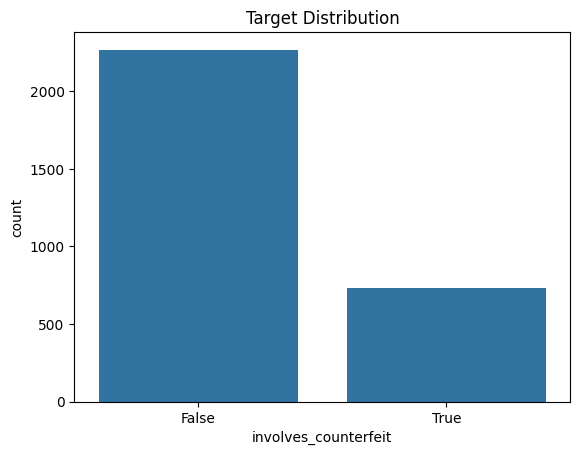

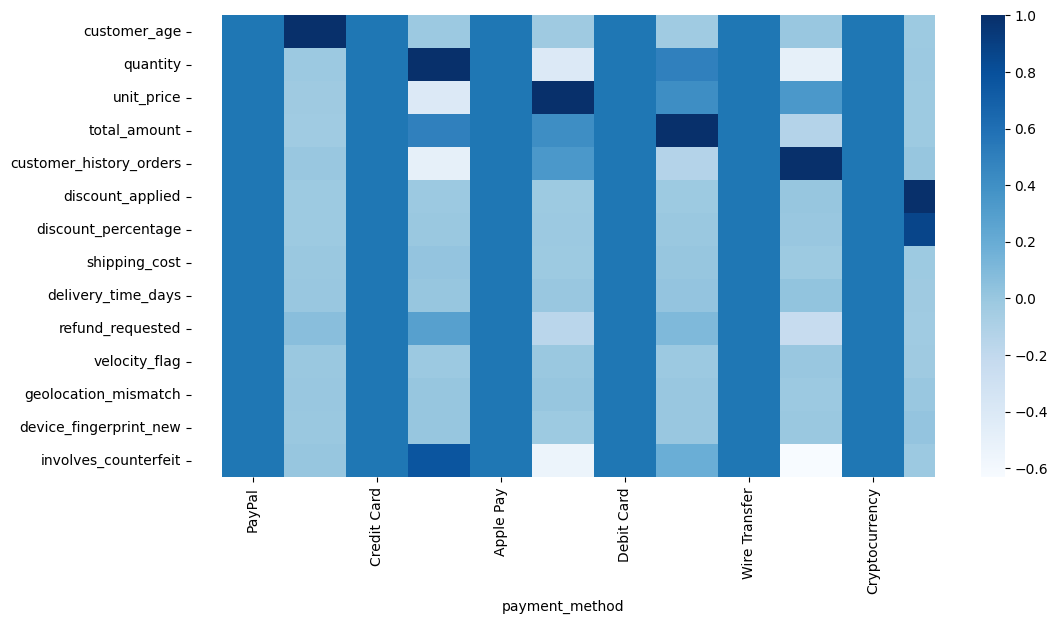

In [42]:
# Plotting
df_transactions.isna().sum()

sns.countplot(x=df_transactions["involves_counterfeit"])
plt.title("Target Distribution")

plt.figure(figsize=(12,6))
sns.heatmap(df_transactions.corr(numeric_only=True), annot=False, cmap="Blues")

df_transactions["payment_method"].value_counts().plot(kind="bar")

In [43]:
X_train, X_test, y_train, y_test, preprocessor = get_transactions_dataset()

# Define the Logistic Regression classifier (linear model for binary classification)
logreg = LogisticRegression(
    max_iter=1000,   # allow more iterations so the optimizer can converge
    random_state=42, # make results reproducible
    n_jobs=-1,       # use all available CPU cores (for solvers that support it)
    class_weight="balanced",

#For LogReg and SVM, you now see:
#Recall = 1.0 → they catch all counterfeit transactions in the test set
#Precision dipped a bit (~0.967) → they flag a few more false positives
#That’s exactly what “balanced” does: it makes the model care more about the minority class, pushing for higher recall.
)

# Build a Pipeline:
# 1) "preprocess" step: applies scaling + one-hot encoding to features
# 2) "model" step: fits Logistic Regression on the transformed features
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", logreg),
])

# Train the pipeline on the training data
clf.fit(X_train, y_train)

# Evaluate the trained model on the test data
evaluate_classifier(
    clf,
    X_test,
    y_test,
    model_name="logreg",
    dataset_name="transactions",
)


=== logreg on transactions ===
Accuracy : 0.9917
Precision: 0.9671
Recall   : 1.0000
F1-score : 0.9833
ROC-AUC  : 0.9999


=== Logistic Regression (transactions) ===
              precision    recall  f1-score   support

           0     1.0000    0.9890    0.9945       453
           1     0.9671    1.0000    0.9833       147

    accuracy                         0.9917       600
   macro avg     0.9836    0.9945    0.9889       600
weighted avg     0.9919    0.9917    0.9917       600

ROC-AUC: 0.9999


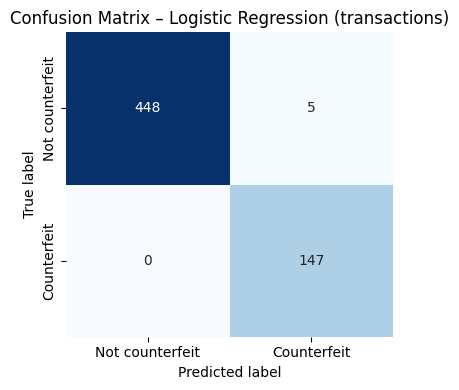

<Figure size 500x400 with 0 Axes>

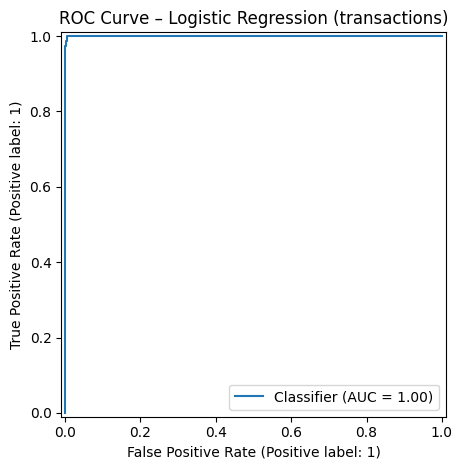

<Figure size 500x400 with 0 Axes>

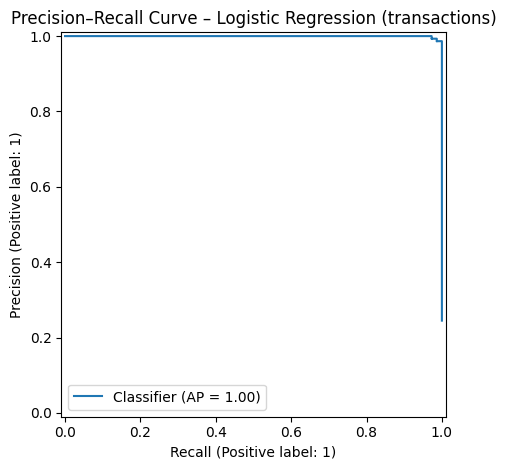

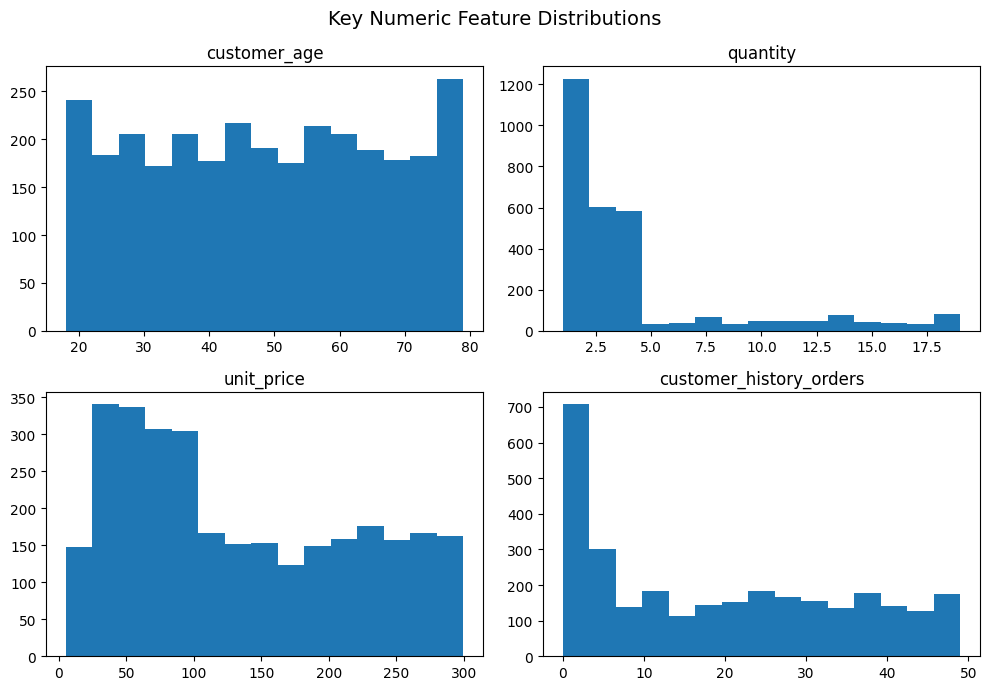

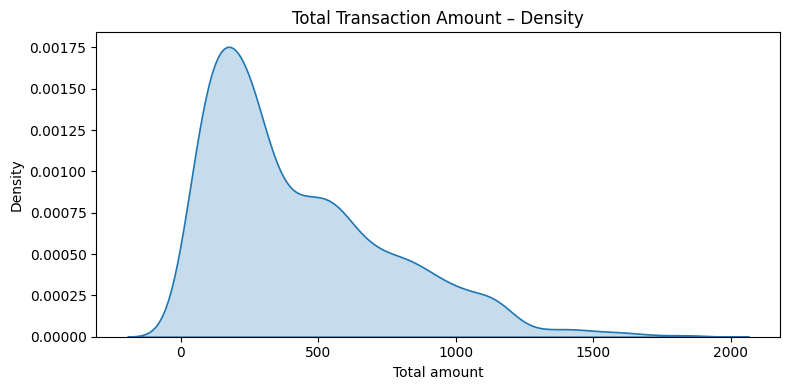

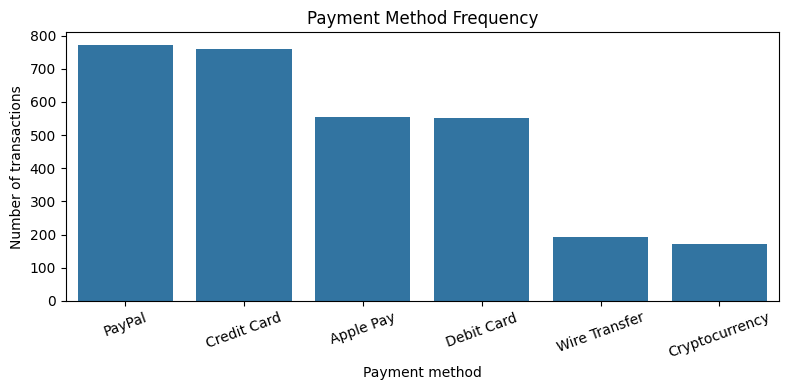

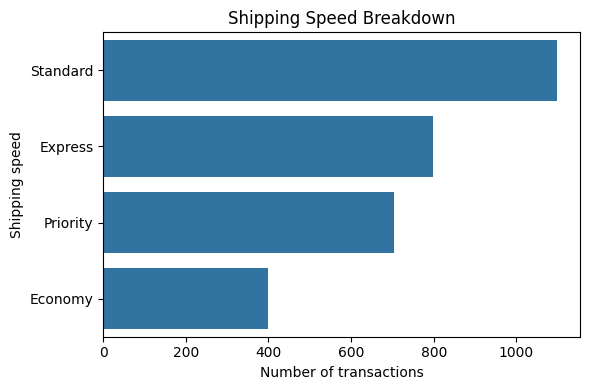

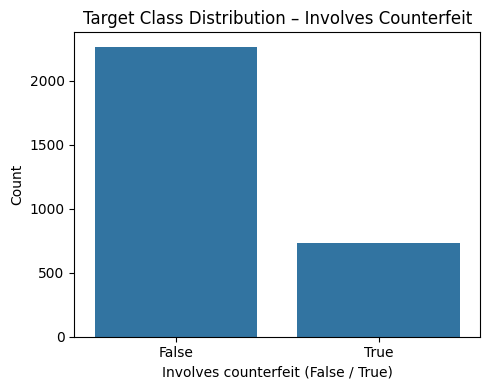

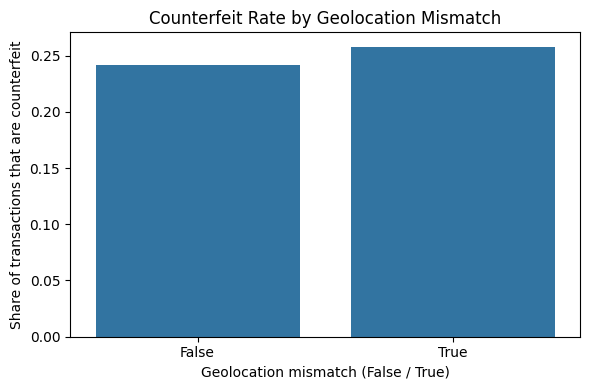

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def evaluate_and_plot_classifier(
    clf,
    X_test,
    y_test,
    model_name: str,
    dataset_name: str = "transactions",
    df=None,  # <-- NEW: pass the full dataframe if you want extra plots
):
    """
    Print metrics + plot confusion matrix, ROC and Precision–Recall curves
    for a fitted classifier. Optionally also plot a few feature distributions
    if `df` (the original DataFrame) is provided.
    """
    # ----- 1. Predictions and scores -----
    y_pred = clf.predict(X_test)

    # Continuous scores for ROC / PR
    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_scores = clf.decision_function(X_test)
    else:
        y_scores = None

    # ----- 2. Text metrics -----
    print(f"=== {model_name} ({dataset_name}) ===")
    print(classification_report(y_test, y_pred, digits=4))

    if y_scores is not None:
        roc = roc_auc_score(y_test, y_scores)
        print(f"ROC-AUC: {roc:.4f}")
    else:
        print("ROC-AUC: N/A (no probability/score output)")

    # ----- 3. Confusion matrix heatmap -----
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Not counterfeit", "Counterfeit"],
        yticklabels=["Not counterfeit", "Counterfeit"],
    )
    plt.title(f"Confusion Matrix – {model_name} ({dataset_name})")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()

    # ----- 4. ROC curve -----
    if y_scores is not None:
        plt.figure(figsize=(5, 4))
        RocCurveDisplay.from_predictions(y_test, y_scores)
        plt.title(f"ROC Curve – {model_name} ({dataset_name})")
        plt.tight_layout()
        plt.show()

        # ----- 5. Precision–Recall curve -----
        plt.figure(figsize=(5, 4))
        PrecisionRecallDisplay.from_predictions(y_test, y_scores)
        plt.title(f"Precision–Recall Curve – {model_name} ({dataset_name})")
        plt.tight_layout()
        plt.show()

    # ----- 6. Dataset-level EDA plots
    if df is not None:
        # 6a. Core numeric features in a 2x2 grid of histograms
        numeric_cols = [
            "customer_age",
            "quantity",
            "unit_price",
            "customer_history_orders",
        ]
        available_numeric = [c for c in numeric_cols if c in df.columns]

        if available_numeric:
            ax_array = df[available_numeric].hist(
                bins=15,
                figsize=(10, 7),
                layout=(2, 2),
                grid=False,
            )
            plt.suptitle("Key Numeric Feature Distributions", fontsize=14)
            plt.tight_layout()
            plt.show()

        # 6b. Total transaction amount distribution (smooth KDE)
        if "total_amount" in df.columns:
            plt.figure(figsize=(8, 4))
            sns.kdeplot(
                data=df,
                x="total_amount",
                fill=True,
                linewidth=1.2,
            )
            plt.title("Total Transaction Amount – Density")
            plt.xlabel("Total amount")
            plt.ylabel("Density")
            plt.tight_layout()
            plt.show()

        # 6c. Payment method counts (categorical)
        if "payment_method" in df.columns:
            plt.figure(figsize=(8, 4))
            order = df["payment_method"].value_counts().index
            sns.countplot(
                data=df,
                x="payment_method",
                order=order,
            )
            plt.title("Payment Method Frequency")
            plt.xlabel("Payment method")
            plt.ylabel("Number of transactions")
            plt.xticks(rotation=20)
            plt.tight_layout()
            plt.show()

        # 6d. Shipping speed counts as a horizontal bar plot
        if "shipping_speed" in df.columns:
            counts = df["shipping_speed"].value_counts()
            plt.figure(figsize=(6, 4))
            sns.barplot(
                x=counts.values,
                y=counts.index,
            )
            plt.title("Shipping Speed Breakdown")
            plt.xlabel("Number of transactions")
            plt.ylabel("Shipping speed")
            plt.tight_layout()
            plt.show()

        # 6e. Counterfeit vs non-counterfeit class balance
        if "involves_counterfeit" in df.columns:
            plt.figure(figsize=(5, 4))
            sns.countplot(
                data=df,
                x="involves_counterfeit",
            )
            plt.title("Target Class Distribution – Involves Counterfeit")
            plt.xlabel("Involves counterfeit (False / True)")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

        # 6f. Geolocation mismatch vs counterfeit rate (simple 2-category bar)
        if {"geolocation_mismatch", "involves_counterfeit"}.issubset(df.columns):
            mismatch_rate = (
                df.groupby("geolocation_mismatch")["involves_counterfeit"]
                .mean()
                .rename("counterfeit_rate")
            )
            plt.figure(figsize=(6, 4))
            sns.barplot(
                x=mismatch_rate.index.astype(str),
                y=mismatch_rate.values,
            )
            plt.title("Counterfeit Rate by Geolocation Mismatch")
            plt.xlabel("Geolocation mismatch (False / True)")
            plt.ylabel("Share of transactions that are counterfeit")
            plt.tight_layout()
            plt.show()


evaluate_and_plot_classifier(
    clf,
    X_test,
    y_test,
    model_name="Logistic Regression",
    dataset_name="transactions",
    df=df_transactions,
)

In [45]:
# Define the KNN classifier
knn = KNeighborsClassifier(
    n_neighbors=5,     # look at 5 nearest neighbors
    weights="distance",# closer neighbors have more influence
    n_jobs=-1,         # use all CPU cores (for distance computations)
)

# Pipeline: preprocessing -> KNN model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", knn),
])

# Train the model
clf.fit(X_train, y_train)

# Evaluate on the test set
evaluate_classifier(
    clf,
    X_test,
    y_test,
    model_name="knn",
    dataset_name="transactions",
)


=== knn on transactions ===
Accuracy : 0.9783
Precision: 0.9653
Recall   : 0.9456
F1-score : 0.9553
ROC-AUC  : 0.9982


=== KNN (transactions) ===
              precision    recall  f1-score   support

           0     0.9825    0.9890    0.9857       453
           1     0.9653    0.9456    0.9553       147

    accuracy                         0.9783       600
   macro avg     0.9739    0.9673    0.9705       600
weighted avg     0.9782    0.9783    0.9783       600

ROC-AUC: 0.9982


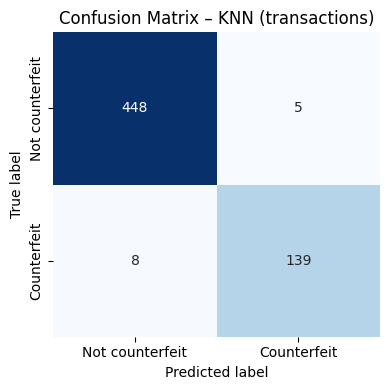

<Figure size 500x400 with 0 Axes>

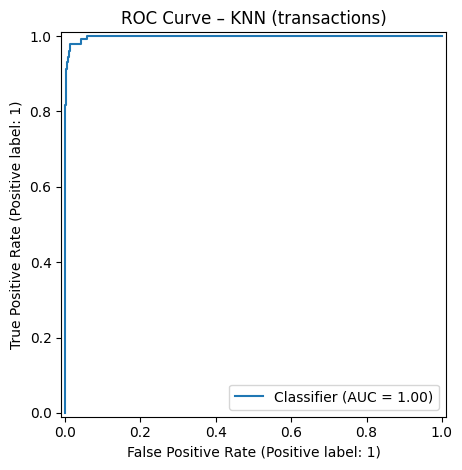

<Figure size 500x400 with 0 Axes>

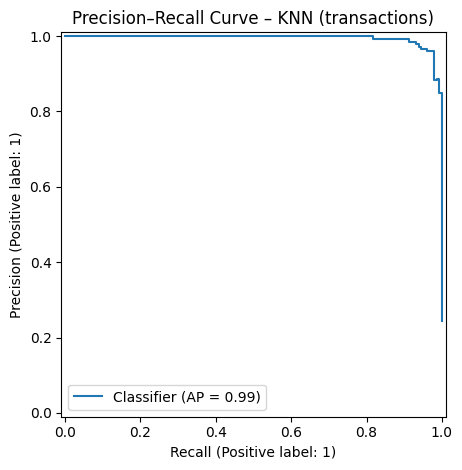

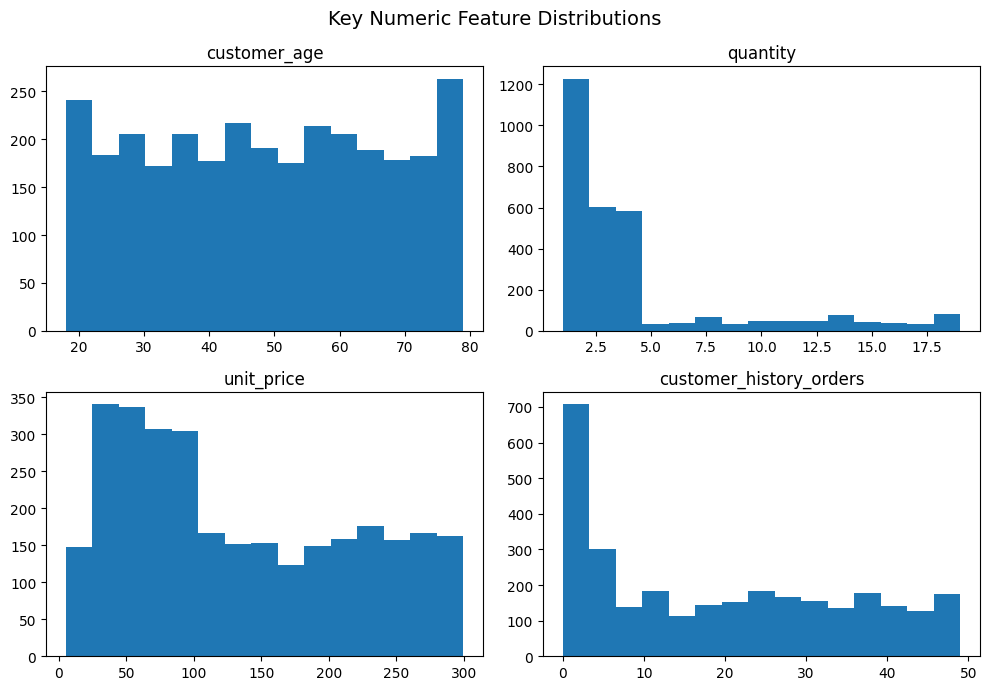

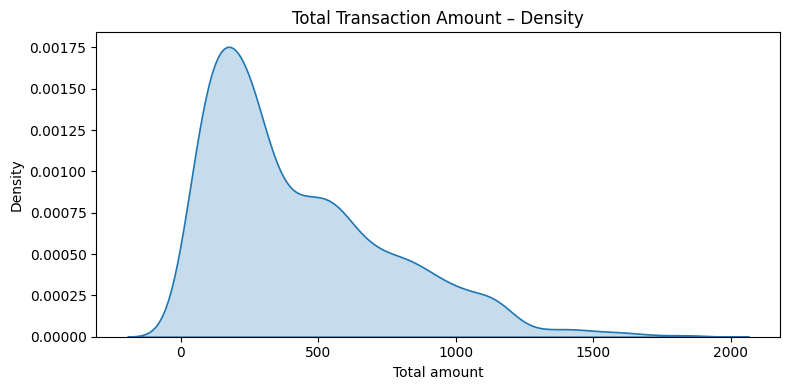

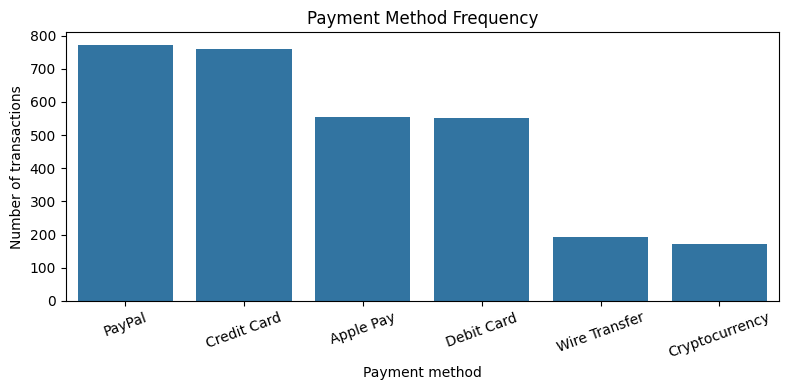

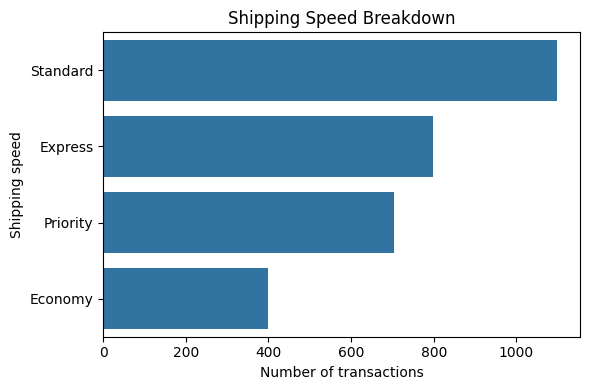

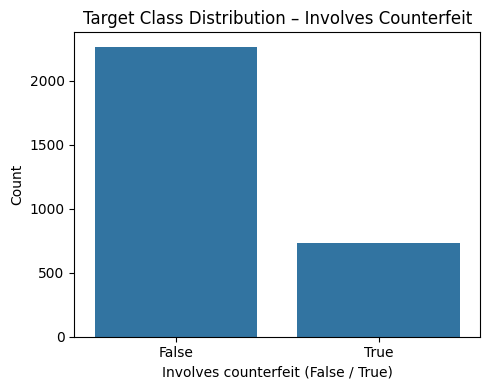

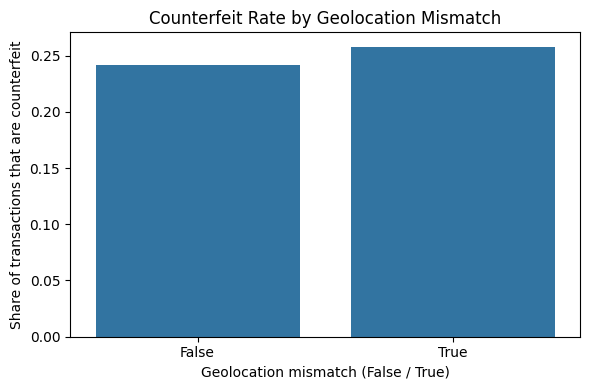

In [46]:
# Plotting
evaluate_and_plot_classifier(
    clf,
    X_test,
    y_test,
    model_name="KNN",
    dataset_name="transactions",
    df=df_transactions,
)


In [47]:
# Define the Gradient Boosting classifier
# (sequentially builds an ensemble of small decision trees)
gb = GradientBoostingClassifier(
    random_state=42,  # for reproducibility
)

# Pipeline: preprocessing -> gradient boosting model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", gb),
])

# Train the model
clf.fit(X_train, y_train)

# Evaluate on the test set
evaluate_classifier(
    clf,
    X_test,
    y_test,
    model_name="gb",
    dataset_name="transactions",
)


=== gb on transactions ===
Accuracy : 0.9950
Precision: 0.9800
Recall   : 1.0000
F1-score : 0.9899
ROC-AUC  : 0.9999


=== Gradient Boosting (transactions) ===
              precision    recall  f1-score   support

           0     1.0000    0.9934    0.9967       453
           1     0.9800    1.0000    0.9899       147

    accuracy                         0.9950       600
   macro avg     0.9900    0.9967    0.9933       600
weighted avg     0.9951    0.9950    0.9950       600

ROC-AUC: 0.9999


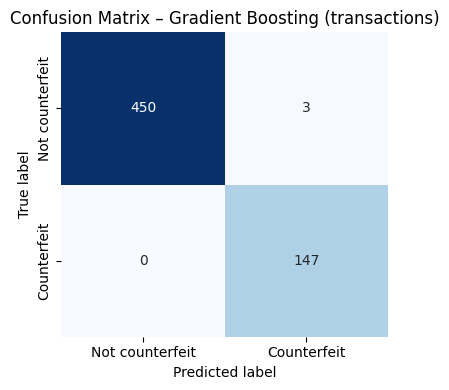

<Figure size 500x400 with 0 Axes>

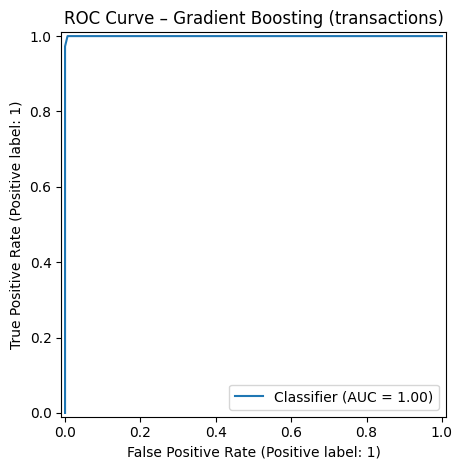

<Figure size 500x400 with 0 Axes>

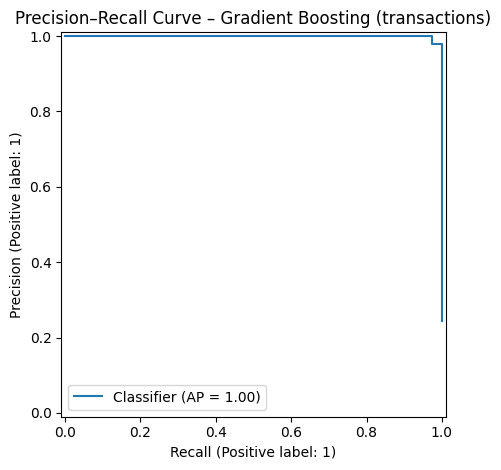

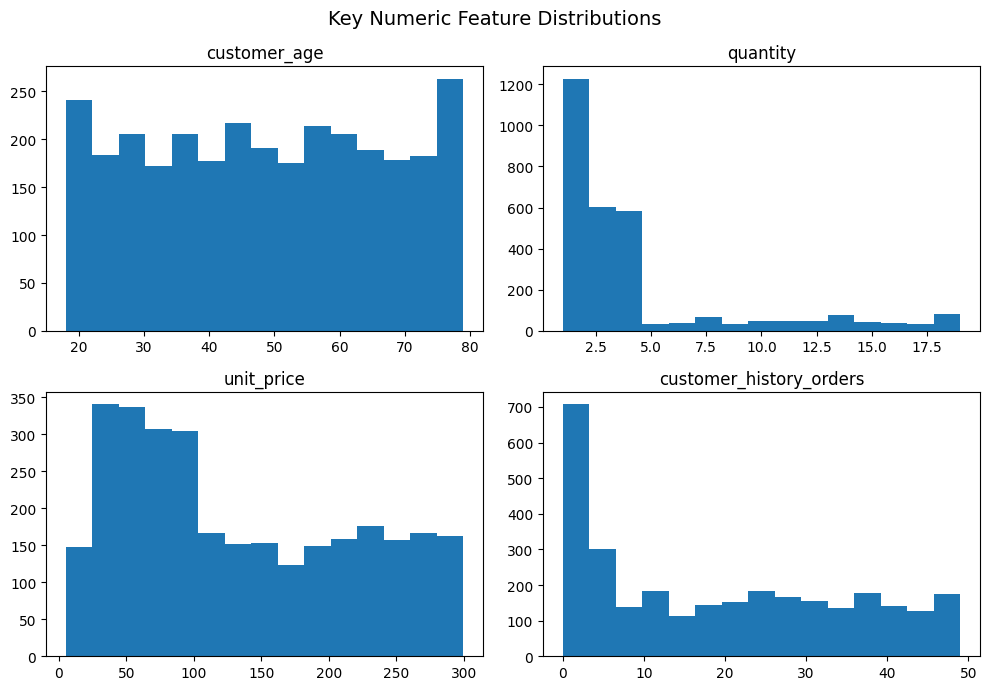

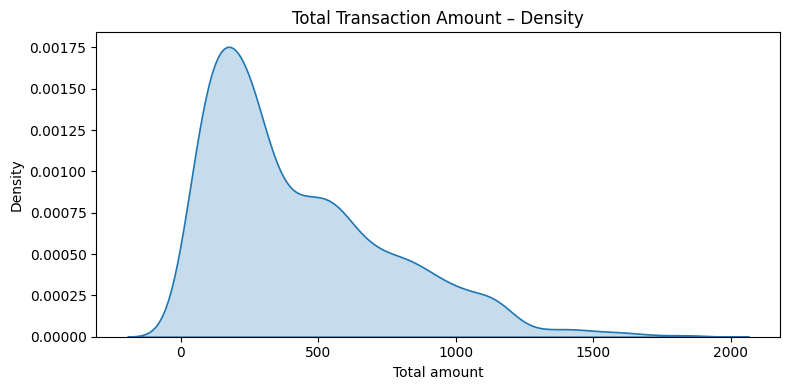

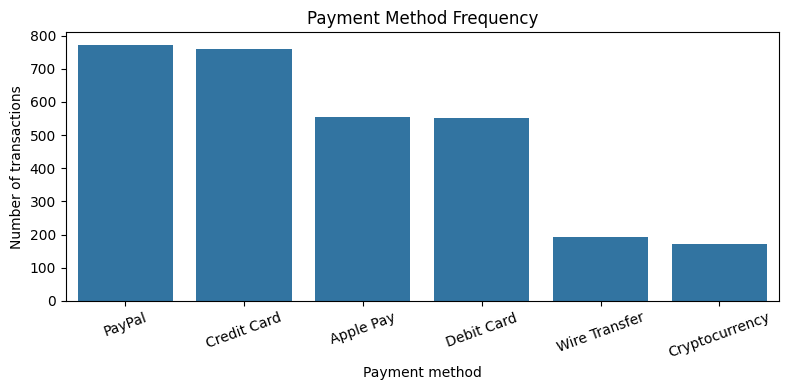

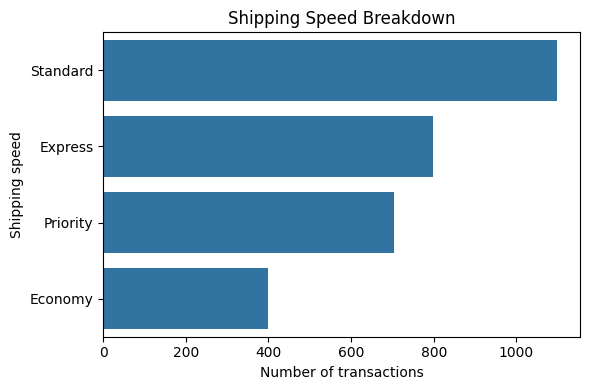

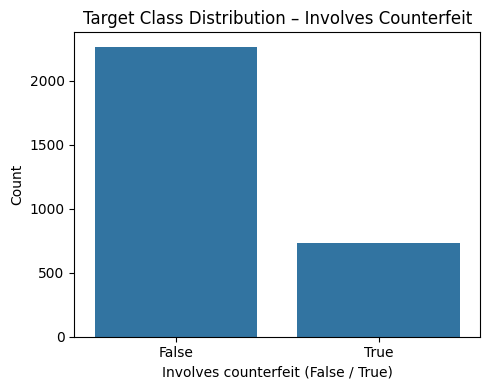

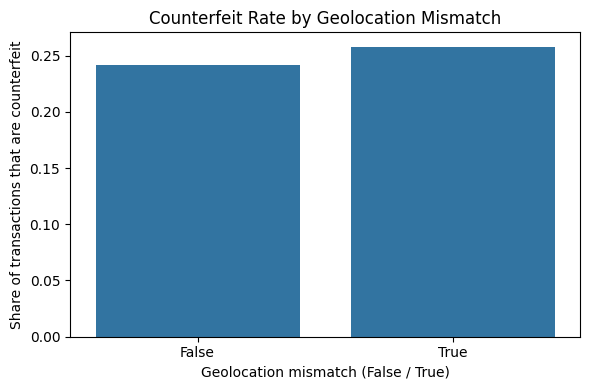

In [48]:
# Plotting
evaluate_and_plot_classifier(
    clf,
    X_test,
    y_test,
    model_name="Gradient Boosting",
    dataset_name="transactions",
    df=df_transactions,
)


In [49]:
# Define the Random Forest model (ensemble of decision trees)
rf = RandomForestClassifier(
    n_estimators=200,   # number of trees in the forest
    max_depth=None,     # trees can grow until leaves are pure or min_samples reached
    random_state=42,    # reproducible results
    n_jobs=-1,          # use all CPU cores
    class_weight="balanced",
)

# Build a Pipeline: first apply preprocessing, then fit the RF model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf),
])

# Fit the pipeline on training data (preprocessing is learned + model is trained)
clf.fit(X_train, y_train)

# Evaluate on test data and print/save metrics + plots
evaluate_classifier(
    clf,
    X_test,
    y_test,
    model_name="rf",
    dataset_name="transactions",
)


=== rf on transactions ===
Accuracy : 0.9950
Precision: 0.9932
Recall   : 0.9864
F1-score : 0.9898
ROC-AUC  : 0.9999


=== Random Forest (transactions) ===
              precision    recall  f1-score   support

           0     0.9956    0.9978    0.9967       453
           1     0.9932    0.9864    0.9898       147

    accuracy                         0.9950       600
   macro avg     0.9944    0.9921    0.9932       600
weighted avg     0.9950    0.9950    0.9950       600

ROC-AUC: 0.9999


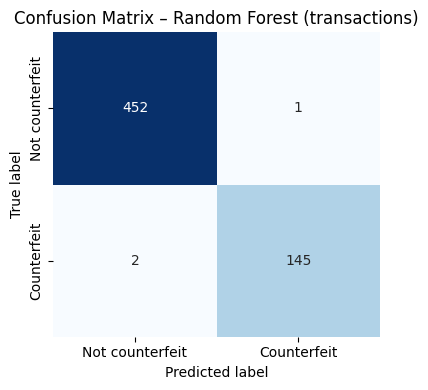

<Figure size 500x400 with 0 Axes>

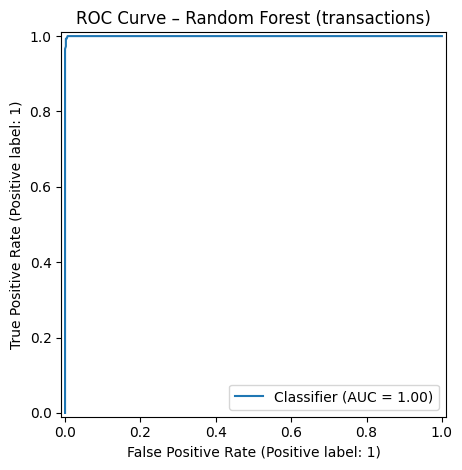

<Figure size 500x400 with 0 Axes>

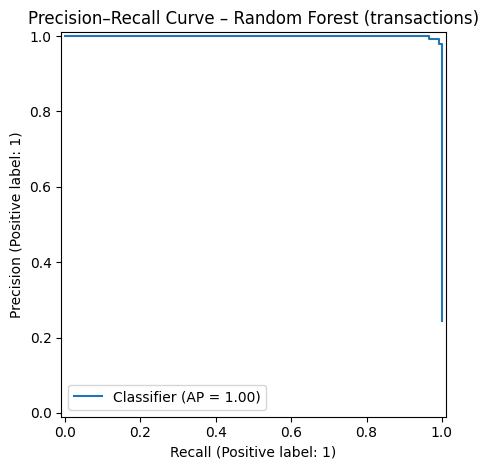

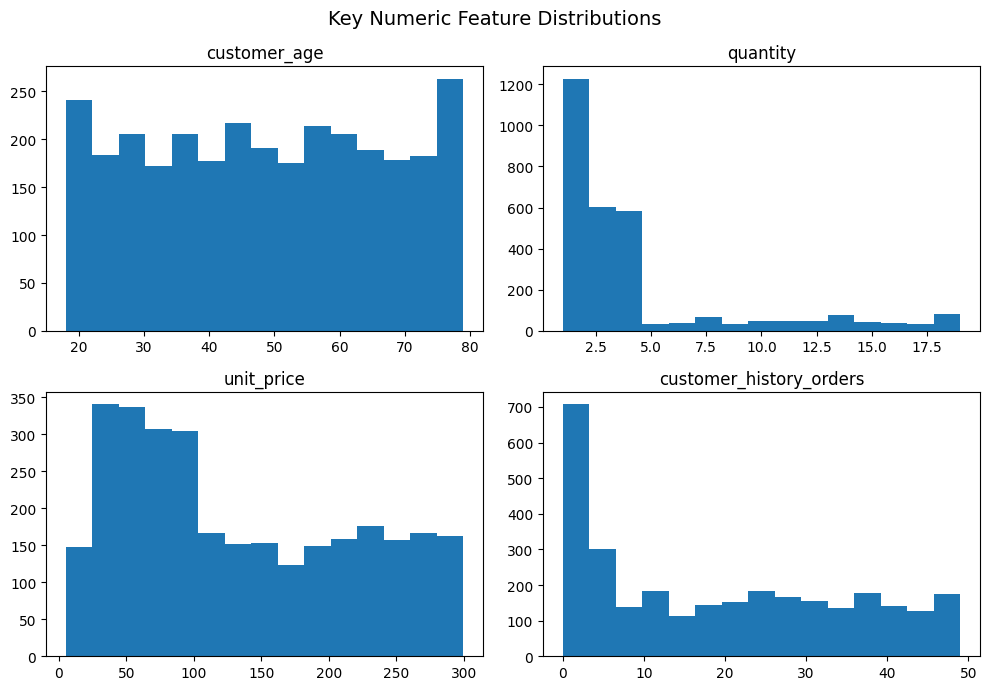

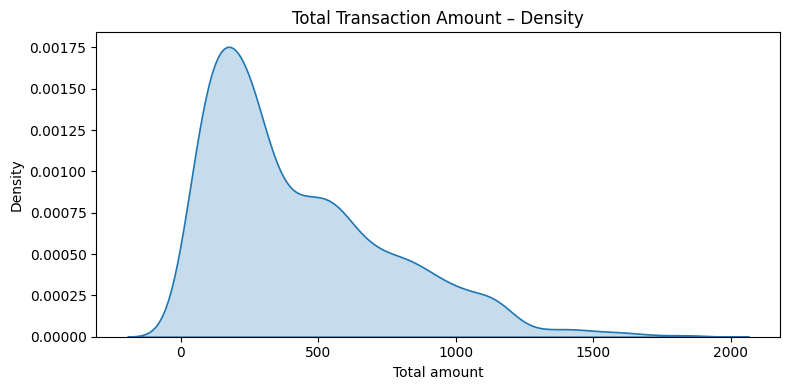

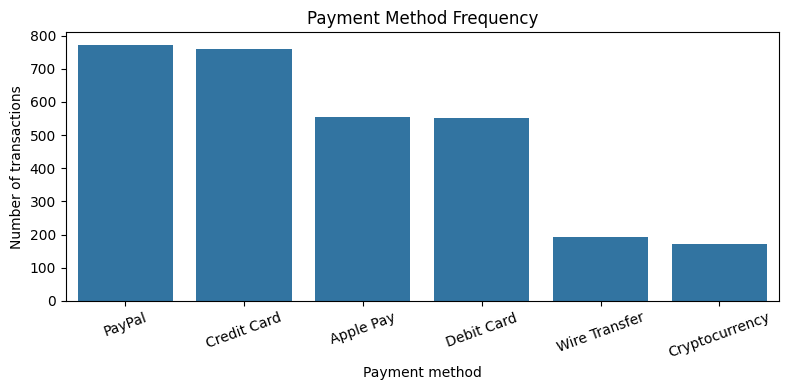

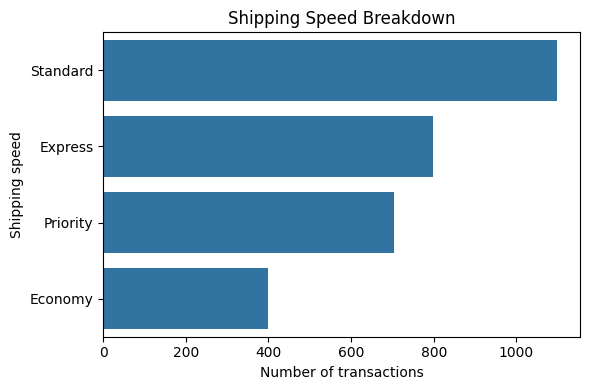

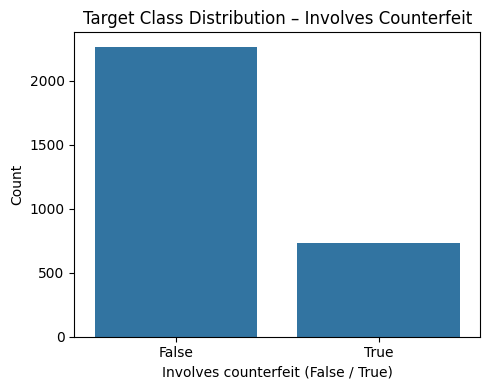

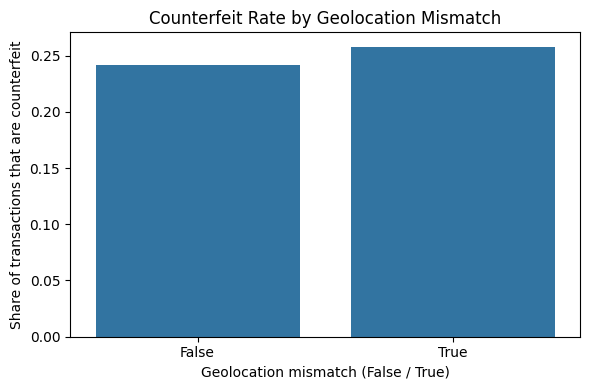

In [50]:
# Plotting
evaluate_and_plot_classifier(
    clf,
    X_test,
    y_test,
    model_name="Random Forest",
    dataset_name="transactions",
    df=df_transactions,
)

In [51]:
# Define an SVM classifier with an RBF kernel
svm = SVC(
    kernel="rbf",       # non-linear kernel (Radial Basis Function)
    probability=True,   # enable probability estimates for ROC-AUC
    random_state=42,    # reproducibility
    class_weight="balanced",
)

# Pipeline: preprocessing -> SVM model
clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", svm),
])

# Train the model
clf.fit(X_train, y_train)

# Evaluate on the test set
evaluate_classifier(
    clf,
    X_test,
    y_test,
    model_name="svm",
    dataset_name="transactions",
)


=== svm on transactions ===
Accuracy : 0.9917
Precision: 0.9671
Recall   : 1.0000
F1-score : 0.9833
ROC-AUC  : 0.9996


=== SVM (RBF) (transactions) ===
              precision    recall  f1-score   support

           0     1.0000    0.9890    0.9945       453
           1     0.9671    1.0000    0.9833       147

    accuracy                         0.9917       600
   macro avg     0.9836    0.9945    0.9889       600
weighted avg     0.9919    0.9917    0.9917       600

ROC-AUC: 0.9996


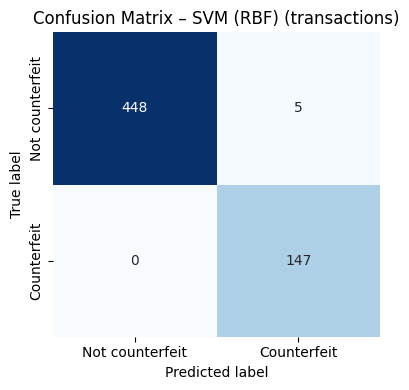

<Figure size 500x400 with 0 Axes>

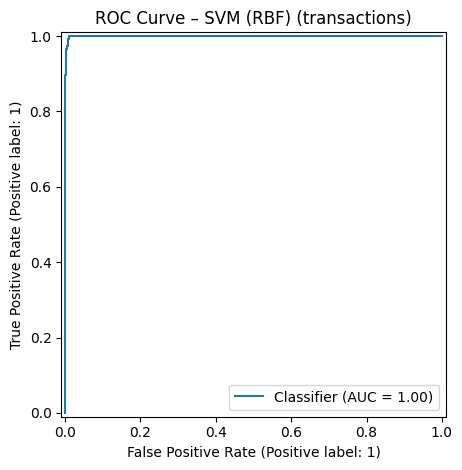

<Figure size 500x400 with 0 Axes>

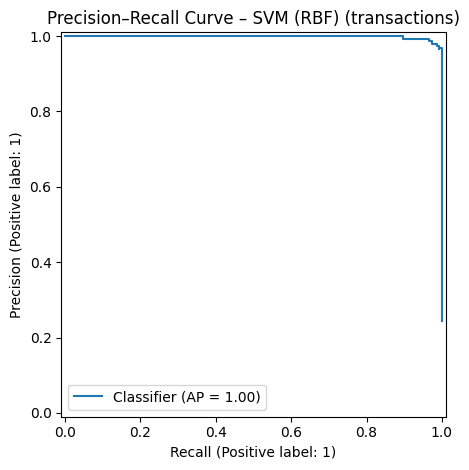

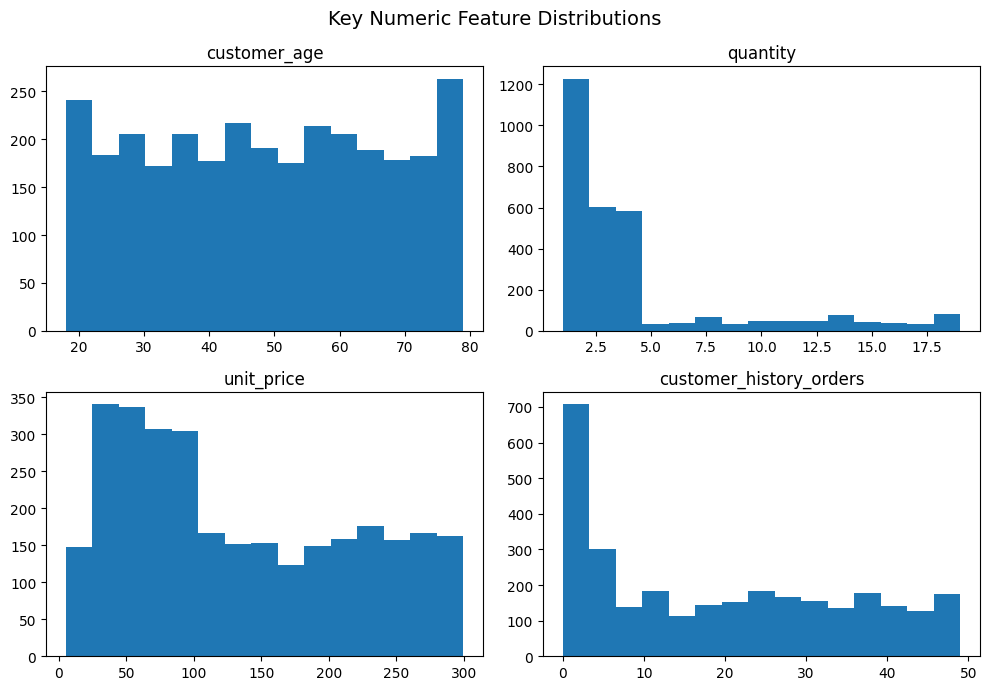

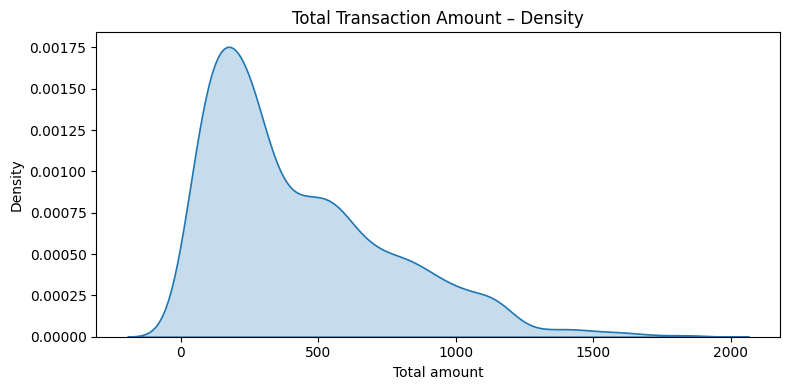

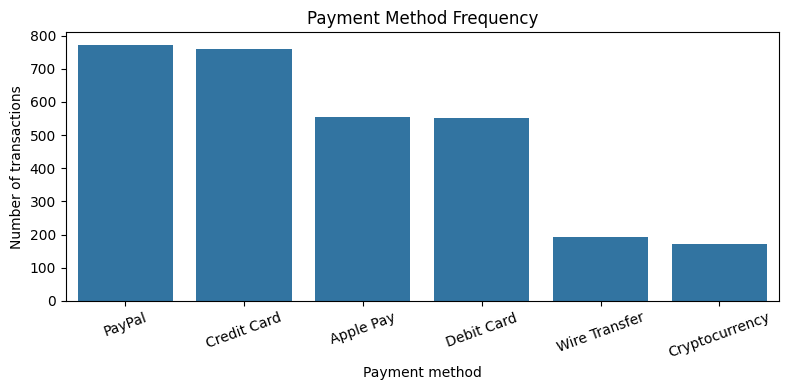

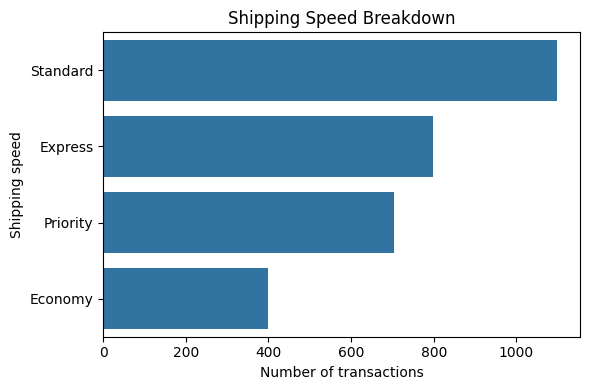

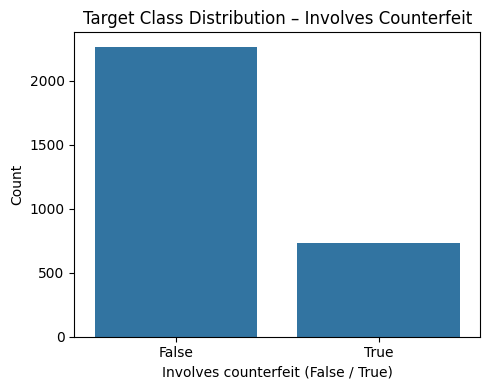

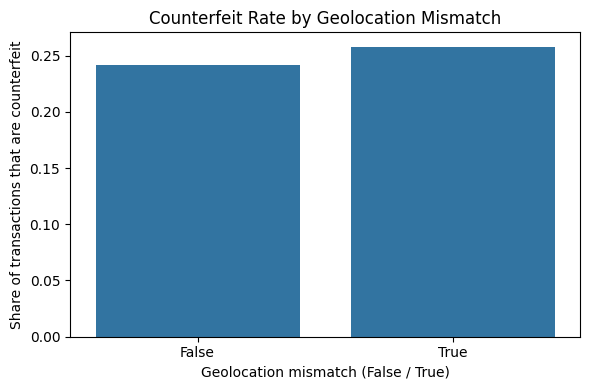

In [52]:
# Plotting
evaluate_and_plot_classifier(
    clf,
    X_test,
    y_test,
    model_name="SVM (RBF)",
    dataset_name="transactions",
    df=df_transactions,
)
